In [2]:
import pandas as pd
import numpy as np
import hdbscan
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import pairwise_distances

import os
os.chdir('../')

from clustering_evaluation import ClusterPurity
evaluator=ClusterPurity()

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  


# Load AI4BD dataset:

In [3]:
# -- load the input dataset--#
input_df=pd.read_csv('./merged.csv', low_memory=False)
input_df.index = 'http://dakiri.org/Event_' + input_df.index.astype(str)
num_rows, num_cols = input_df.shape  # at max num_rows times num_cols columns.
column_names = input_df.columns
    
print ('Input data loaded with shape', input_df.shape)     

Input data loaded with shape (2974716, 41)


## Sampling the dataset with balanced classes:

In [4]:
sample_stockChange=input_df[input_df['type']=='stock change'].sample(n=71152)
order_type=input_df[input_df['type']=='order']
concated_df=pd.concat([sample_stockChange, order_type])


In [5]:
sample_df=concated_df.sample(frac=0.5, random_state=42)

## Encode Event Types ['order', 'stock change']

In [6]:
# binarize string_labels in ['type']
lb=LabelBinarizer()
event_labels=lb.fit_transform(sample_df['type'].tolist())
lb.classes_

array(['order', 'stock change'], dtype='<U12')

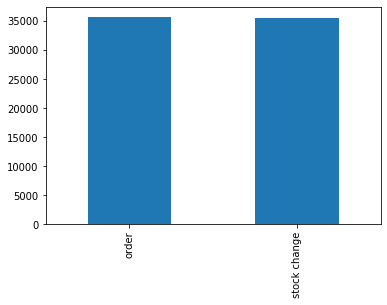

In [7]:
pd.value_counts(sample_df['type'], normalize=False).plot.bar()

# Load KG Embeddings using Pyke for AI4BD dataset:

In [8]:
#-- load the embeddings data --#
embedding_input=pd.read_csv("/home/datascienceadmin/hzahera/DAIKIRI Experiments/vectograph/Vectograph_Results/2020-10-27 10:51:09.670578/PYKE_200_embeddings.csv", index_col=0)

#consider only events embedding (Event_id)
embedding_index=embedding_input.index.tolist()
prefix = 'http://dakiri.org/Event_'
event_ids=list(filter(lambda x: x.startswith(prefix), embedding_index))
events_df=embedding_input.loc[event_ids]

In [9]:
# Getting events embedding..
eventEmb_sample=events_df.loc[sample_df.index]
# To verify, we retrieve the correct embeddings by event id
sample_df.index.equals(eventEmb_sample.index)

eventEmb_sample.shape

(71152, 200)

# Dataset Split

In [10]:
# split the dataset into train-test split
X_train, X_test, y_train, y_test = train_test_split( eventEmb_sample.values, event_labels, test_size=0.33, random_state=42)

# Unsupervised Clustering:

## HDBSCAN

In [11]:
from joblib import Memory

cachedir = './'
mem = Memory(cachedir, verbose=0)

In [12]:
#distance_matrix = pairwise_distances(eventEmb_sample, metric='cosine', n_jobs=-1)
distance_test = pairwise_distances(X_test, metric='cosine', n_jobs=-1)

In [15]:
clusterer_precomputed=hdbscan.HDBSCAN(algorithm='best', alpha=1.3, metric='precomputed',
                                      min_samples=1000, min_cluster_size=1000, cluster_selection_method='leaf' ,
                                      core_dist_n_jobs=-1,  cluster_selection_epsilon=0.5 ,allow_single_cluster=True,memory=mem)


clusterer_precomputed.fit(distance_test)

cluster_labels=clusterer_precomputed.labels_

print ('cluster labels: ', set(cluster_labels))

y_list=cluster_labels.tolist()
print (y_list.count(0), y_list.count(1), y_list.count(-1))

cluster labels:  {0, 1, -1}
9225 14139 117


/home/datascienceadmin/anaconda3/envs/ven_deep1/lib/python3.7/site-packages/hdbscan/hdbscan_.py:600: UserWarning: Persisting input arguments took 7.17s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  gen_min_span_tree, **kwargs)


In [16]:

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, cluster_labels)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, cluster_labels, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, cluster_labels, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, cluster_labels, average='weighted')
print('F1 score: %f' % f1)

print ('Purity: ' , evaluator.purity_score(y_true=y_test, y_pred=cluster_labels))

Accuracy: 0.551169
Precision: 0.555721
Recall: 0.551169
F1 score: 0.547340
Purity:  0.5558110812997743


/home/datascienceadmin/anaconda3/envs/ven_deep1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

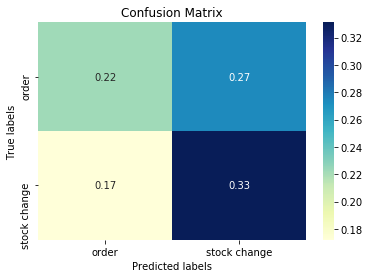

In [17]:
labels=[0, 1]
cm= confusion_matrix(y_test, cluster_labels, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])


## Random Clustering:

In [19]:
y_random=np.random.choice([0, 1], size=y_test.shape[0])

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_random)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_random, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_random, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_random, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_test, y_pred=y_random))

Accuracy: 0.501384
Precision: 0.501388
Recall: 0.501384
F1 score: 0.501384
Purity:  0.5013840977811848


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

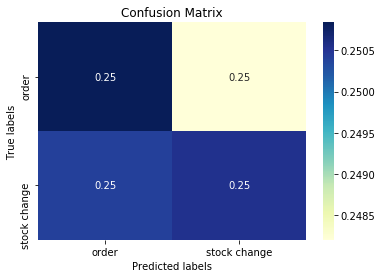

In [20]:
labels=[0, 1]
cm= confusion_matrix(y_test, y_random, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])

## AgglomerativeClustering

In [21]:
from sklearn.cluster import AgglomerativeClustering
aggclustering = AgglomerativeClustering(n_clusters=2).fit(X_train)

y_aggClustering=aggclustering.fit_predict(X_test)

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_aggClustering)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_aggClustering, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_aggClustering, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_aggClustering, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_test, y_pred=y_aggClustering))

Accuracy: 0.498999
Precision: 0.249032
Recall: 0.498999
F1 score: 0.332250
Purity:  0.5010008091648567


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

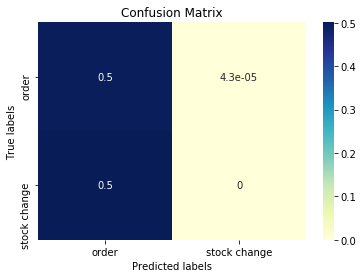

In [22]:
labels=[0, 1]
cm= confusion_matrix(y_test, y_aggClustering, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])

## K-Means

In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, random_state=42).fit(X_train)
y_kmeans=kmeans.predict(X_test)

    #----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_kmeans)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_kmeans, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_kmeans, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_kmeans, average='weighted')
print('F1 score: %f' % f1)
print ('Purity: ' , evaluator.purity_score(y_true=y_test, y_pred=y_kmeans))

Accuracy: 0.498871
Precision: 0.249000
Recall: 0.498871
F1 score: 0.332194
Purity:  0.501128572036966


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

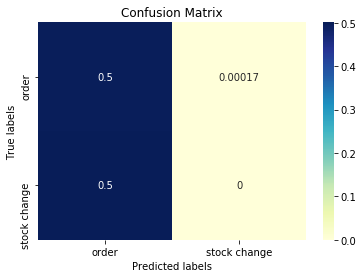

In [24]:
labels=[0, 1]
cm= confusion_matrix(y_test, y_kmeans, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])

# Supervised Baselines:

## Logisitc Regression

In [26]:
from sklearn.linear_model import LogisticRegression

logistic_clf = LogisticRegression(solver='liblinear',random_state=42).fit(X_train, y_train.ravel())
y_lr = logistic_clf.predict(X_test)

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_lr)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_lr, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_lr, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_lr, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_lr))

Accuracy: 0.499042
Precision: 0.249043
Recall: 0.499042
F1 score: 0.332269
Purity Score:  0.5009582215408203


/home/datascienceadmin/anaconda3/envs/ven_deep1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

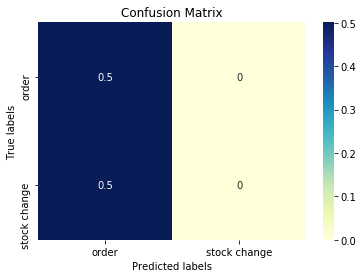

In [27]:
labels=[0, 1]
cm= confusion_matrix(y_test, y_lr, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])

## KNN:

In [28]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train.ravel())
y_knn = neigh.predict(X_test)

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_knn)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_knn, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_knn, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_knn, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_knn))

Accuracy: 0.922618
Precision: 0.922645
Recall: 0.922618
F1 score: 0.922618
Purity Score:  0.9226182871257612


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

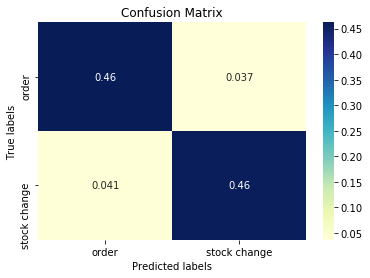

In [29]:
labels=[0, 1]
cm= confusion_matrix(y_test, y_knn, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])

## RandomForest:

In [30]:
from sklearn.ensemble import RandomForestClassifier

random_clf = RandomForestClassifier(random_state=42).fit(X_train, y_train.ravel())
y_rf= random_clf.predict(X_test)

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_rf)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_rf, average='weighted')
print('Precision: %f' % precision)

recall = recall_score(y_test, y_rf, average='weighted')
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_rf, average='weighted')
print('F1 score: %f' % f1)

print('Purity Score: ', evaluator.purity_score(y_true=y_test, y_pred=y_rf))

Accuracy: 0.499042
Precision: 0.249043
Recall: 0.499042
F1 score: 0.332269
Purity Score:  0.5009582215408203


/home/datascienceadmin/anaconda3/envs/ven_deep1/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

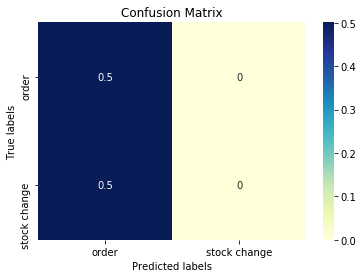

In [31]:
labels=[0, 1]
cm= confusion_matrix(y_test, y_rf, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])